In [1]:
# sun pos
# https://github.com/s-bear/sun-position?tab=readme-ov-file
!pip install sunposition
!pip install ephem
df = None
import cygno as cy
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import uproot
sns.set()
runInfo=cy.read_cygno_logbook(sql=True)
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from skimage.measure import LineModelND, ransac, CircleModel


def Gauss3(x, a0, x0, s0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))

def runsac_ply_fit(x_values, y_values, ax, poly_degree = 1):

    from sklearn.linear_model import (
        LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
    #
    # different regression method can be apply 
    # see https://scikit-learn.org/stable/auto_examples/linear_model/plot_robust_fit.html#sphx-glr-auto-examples-linear-model-plot-robust-fit-py
    # see below
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline

#    plt.plot(x_values, y_values, 'r.')
    x_plot = np.linspace(x_values.min(), x_values.max())
    X = np.array(x_values)[:, np.newaxis]

    model = make_pipeline(PolynomialFeatures(poly_degree), RANSACRegressor(min_samples=2,
                                                                           residual_threshold=2,
                                                                           max_trials=1000,
                                                                           random_state=42))
    model.fit(X, y_values)
    mse = mean_squared_error(model.predict(X), y_values)

    y_plot = model.predict(x_plot[:, np.newaxis])
    ax.plot(x_plot, y_plot, 'g-', label='error = %.3f' % (mse))
#    ax.legend()
    return ax

     |################################| 1.8 MB 6.1 MB/s            


![Image of Yaktocat](https://upload.wikimedia.org/wikipedia/commons/b/b1/Azimuth-Altitude_schematic_it.svg)

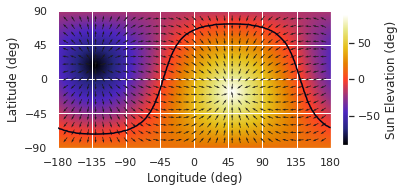

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#sunposition will use numba.jit if available, which may negatively
#impact performance if few positions are being computed.
#To disable jit, before importing sunposition, either set 
#the environment variable NUMBA_DISABLE_JIT to 1 or
#set numba.config.DISABLE_JIT = False
# e.g. import os; os.environ['NUMBA_DISABLE_JIT'] = 1
# or import numba; numba.config.DISABLE_JIT = True
from sunposition import sunpos
from datetime import datetime

#evaluate on a 2 degree grid
lon  = np.linspace(-180,180,181)
lat = np.linspace(-90,90,91)
LON, LAT = np.meshgrid(lon,lat)
#at the current time
now = datetime.utcnow()
az,zen = sunpos(now,LAT,LON,0)[:2] #discard RA, dec, H
#convert zenith to elevation
elev = 90 - zen
#convert azimuth to vectors
u, v = np.cos((90-az)*np.pi/180), np.sin((90-az)*np.pi/180)
#plot
fig, ax = plt.subplots(figsize=(6,3))#,layout='constrained')
img = ax.imshow(elev,cmap=plt.cm.CMRmap,origin='lower',vmin=-90,vmax=90,extent=(-181,181,-91,91))
s = slice(5,-1,5) # equivalent to 5:-1:5
ax.quiver(lon[s],lat[s],u[s,s],v[s,s],pivot='mid',scale_units='xy')
ax.contour(lon,lat,elev,[0])
ax.set_aspect('equal')
ax.set_xticks(np.arange(-180,181,45))
ax.set_yticks(np.arange(-90,91,45))
ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')
cb = plt.colorbar(img,ax=ax,shrink=0.8,pad=0.03)
cb.set_label('Sun Elevation (deg)')
#display plot
plt.show() #unnecessary in interactive sessions


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sunposition import sunpos
from datetime import datetime, timedelta
# LNGS
# Latitude: 42° 27' 36.00" N
# Longitude: 13° 34' 12.00" E
# https://www.google.com/maps/@42.4531033,13.5739044,2a,75y,321.82h,74.37t/data=!3m6!1e1!3m4!1sqZGY4X4xjCUWhz8hr-eVHQ!2e0!7i13312!8i6656?entry=ttu
now = datetime.utcnow()
print(now)
LAT = 42.4531033
LON = 13.5739044
ele = 1000 # quale e' l'elevazione?

2024-02-01 08:56:00.610070


In [4]:
sunpos(now,LAT,LON,ele) 

(array(142.99745802),
 array(68.11254272),
 array(314.43791683),
 array(-17.20225095),
 array(-35.78800643))

In [5]:
base = datetime(2024, 12, 27)
day = base.strftime('%Y-%m-%d ')
daily_hours = np.array([base + timedelta(hours=i) for i in range(24)])
daily_minutes = np.arange(day+'00:00', day+'23:59', dtype='M8').astype(datetime)
tserie = daily_minutes
# tserie = daily_minutes # per calcolare bene sunset e suna rise usare il minuti
tick = int(len(tserie)/2)

In [6]:
az,zen = sunpos(tserie,LAT,LON,0)[:2]

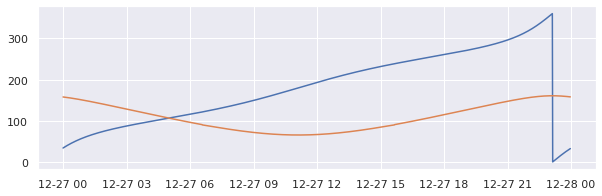

In [7]:
fig, ax = plt.subplots(figsize=(10,3))
plt.plot(tserie, az)
plt.plot(tserie, zen)
plt.show()

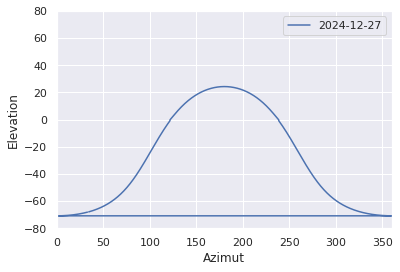

In [8]:
plt.plot(az, 90-zen, label=base.strftime('%Y-%m-%d'))
plt.xlim(0,360)
plt.ylim(-80,80)
plt.xlabel('Azimut')
plt.ylabel('Elevation')
plt.legend()
plt.show()

In [9]:
# per calcolare bene sunset e suna rise usare il minuto almeno
idx = np.abs(90-zen)[:tick].argmin()
print("Sunrise (UTC): "+tserie[idx].strftime('%Y-%m-%d %H:%M'))
idy = np.abs((90-zen)[tick:]).argmin()
print("Sunset (UTC): "+tserie[tick+idy].strftime('%Y-%m-%d %H:%M'))

Sunrise (UTC): 2024-12-27 06:36
Sunset (UTC): 2024-12-27 15:38


In [10]:
import ephem
# test ephem e sunposition a confront
def posizione_astro(latitudine, longitudine, altezza, giorno, ora):
    osservatore = ephem.Observer()
    osservatore.lat = str(latitudine)
    osservatore.long = str(longitudine)
    osservatore.date = giorno + ' ' + ora
    osservatore.elevation = altezza

    astro = ephem.Sun()  # Utilizziamo l'oggetto Sun per il Sole
#    astro = ephem.Moon()
#    astro = ephem.star('Deneb') # stella al centro del cigno
    astro.compute(osservatore)

    altitudine = float(astro.alt) * 180.0 / ephem.pi  # Converti in gradi
    azimuth = float(astro.az) * 180.0 / ephem.pi  # Converti in gradi

    return altitudine, azimuth

now = datetime.utcnow()            # va usata l'ora UTC
latitudine  = 41.975145            # Campaegli
longitudine = 13.103144 
giorno = now.strftime('%Y-%m-%d')  # Data desiderata
ora = now.strftime('%H:%M:%S')     # Ora desiderata (formato HH:MM:SS)
#ora = '15:43:00'
altezza = 1429

alt, az = posizione_astro(latitudine, longitudine, altezza, giorno, ora)
print(f"Posizione approssimativa - Altitudine: {alt} gradi, Azimuth: {az} gradi")
sole = sunpos(now,latitudine,longitudine,altezza)
print(90 - sole[1], sole[0] )

Posizione approssimativa - Altitudine: 22.060868981359203 gradi, Azimuth: 142.46465944401623 gradi
22.064450781693182 142.46920410531283


In [11]:
# genera plk selezione 
def start2epoch(sql_Log, run):
    from datetime import datetime
    date = str(sql_Log[sql_Log.run_number==run].start_time.values[0])
    utc_time = datetime.strptime(date, "%Y-%m-%dT%H:%M:%S.000000000")
    epoch_time = (utc_time - datetime(1970, 1, 1)).total_seconds()
    return epoch_time

def where_astro(dechi, latitudine, longitudine, altezza, data):
    # https://static.coderdojotrento.it//raspberry/tutorial/astropi-2-pyephem/tutorial-astropi-2-pyephem.pdf
    import ephem
    osservatore = ephem.Observer()
    osservatore.lat = str(latitudine)
    osservatore.long = str(longitudine)
    osservatore.date = data
    osservatore.elevation = altezza
    if dechi == 'sun':
        astro = ephem.Sun()  # Utilizziamo l'oggetto Sun per il Sole
    elif dechi == 'cygno':
        astro = ephem.star('Deneb')
    elif dechi == 'moon':
        astro = ephem.Moon()
    else:
        print('nessun astro selezionato')
        return 0,0
    astro.compute(osservatore)

    altitudine = float(astro.alt) * 180.0 / ephem.pi  # Converti in gradi
    azimuth = float(astro.az) * 180.0 / ephem.pi  # Converti in gradi

    return altitudine, azimuth

def anal_theta(dfall):
    data_to_save = {}
    fake_cut = (np.hstack(dfall.sc_rms)>6) & (0.152 * np.hstack(dfall.sc_tgausssigma) > 0.5) \
                & (np.hstack(dfall.sc_integral) > 1000)
    geo_cut = (np.hstack(dfall.sc_xmin)>400) & (np.hstack(dfall.sc_xmax)<1900) \
               & (np.hstack(dfall.sc_ymax)<1900) & (np.hstack(dfall.sc_ymin)>400)
    
    data_to_save['th0'] = 360*np.arctan2((np.hstack(dfall.sc_ymax)-
                          np.hstack(dfall.sc_ymin)), 
                         (np.hstack(dfall.sc_xmax)-
                          np.hstack(dfall.sc_xmin)))/np.pi

    data_to_save['thf'] = 360*np.arctan2((np.hstack(dfall.sc_ymax)[fake_cut]-
                          np.hstack(dfall.sc_ymin)[fake_cut]), 
                         (np.hstack(dfall.sc_xmax)[fake_cut]-
                          np.hstack(dfall.sc_xmin)[fake_cut]))/np.pi
    
    data_to_save['thg'] = 360*np.arctan2((np.hstack(dfall.sc_ymax)[geo_cut]-
                          np.hstack(dfall.sc_ymin)[geo_cut]), 
                         (np.hstack(dfall.sc_xmax)[geo_cut]-
                          np.hstack(dfall.sc_xmin)[geo_cut]))/np.pi
    
    data_to_save['tht'] = 360*np.arctan2((np.hstack(dfall.sc_ymax)[fake_cut & geo_cut]-
                          np.hstack(dfall.sc_ymin)[fake_cut & geo_cut]), 
                         (np.hstack(dfall.sc_xmax)[fake_cut & geo_cut]-
                          np.hstack(dfall.sc_xmin)[fake_cut & geo_cut]))/np.pi
    
    data_to_save['tht2'] = 360*np.arctan2((np.hstack(dfall.sc_ymax)[fake_cut & (np.hstack(dfall.sc_length)>1700)]-
                           np.hstack(dfall.sc_ymin)[fake_cut & (np.hstack(dfall.sc_length)>1700)]), 
                          (np.hstack(dfall.sc_xmax)[fake_cut & (np.hstack(dfall.sc_length)>1700)]-
                           np.hstack(dfall.sc_xmin)[fake_cut & (np.hstack(dfall.sc_length)>1700)]))/np.pi
    return data_to_save

def theta_track(start_run, end_run,verbose=False):
    import numpy as np
    import pandas as pd
    import cygno as cy
    import os
    from datetime import datetime
    try:
        runInfo=cy.read_cygno_logbook(sql=True,verbose=verbose)
        if verbose: print(runInfo)
    except Exception as e:
        print('DB ERROR >>> {}'.format(e))
    
    #runSel = runInfo.loc[runInfo.run_description.str.contains('Stability')]
    #runSel = runInfo.loc[runInfo.run_description == 'Standard']
    runSel = runInfo
    
    df = pd.DataFrame(columns = ['run','epoch','tht', 'fft','rate', 'th0_main', 'th0_std','tht_main', 
                                 'tht_std','thl_main', 'thl_std', 'alt_sun', 'az_sun', 'alt_cygno', 
                                 'az_cygno'])
    latitudine = 42.4531033
    longitudine = 13.5739044
    altezza = 1000 # quale e' l'elevazione?
    
    for i, run in enumerate(runSel[(runSel.run_number>=start_run) & 
                                   (runSel.run_number<=end_run)].run_number):

        if (runSel[runSel.run_number==run].online_reco_status.values[0]==1 and \
           runSel[runSel.run_number==run].pedestal_run.values[0]==0) and \
            runInfo[runInfo.run_number==run].source_type.values[0]==0:
            try:
                print("analyzing run: ",run, str(runSel[runSel.run_number==run].run_description.values))
                run_name = '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/'+'reco_run{0:05d}_3D.pkl.gz'.format(run)
                dfall=pd.read_pickle(run_name, compression={'method': 'gzip'})
                
                data_theta = anal_theta(dfall)
                th0 = np.array(data_theta['th0'])
                thf = np.array(data_theta['thf'])
                thg = np.array(data_theta['thg'])
                # tht = np.array(data_theta['tht'])
                tht = np.array(data_theta['tht2'])
                epoch = start2epoch(runSel, run)
                data_time = datetime.fromtimestamp(epoch).strftime('%Y-%m-%d %H:%M:%S')
                alt_sun, az_sun = where_astro('sun', latitudine, longitudine, 
                                                  altezza, data_time)
                alt_cygno, az_cygno = where_astro('cygno', latitudine, longitudine, 
                                                      altezza, data_time)
                rate = len(tht)
                df.loc[i] = [run, epoch, tht, np.fft.rfft(tht), rate, th0.mean(), th0.std(), tht.mean(),
                             tht.std(), tht2.mean(), tht2.std(), alt_sun, az_sun, alt_cygno, az_cygno]


            except Exception as e:
                print("ERROR>>> ", e)
    
    print("DONE")
    return df



In [60]:
#df.to_pickle('/jupyter-workspace/cloud-storage/cygno-analysis/pkl/df.pkl')

### data generator ----------------------------------- (togliere commento if ...)

In [15]:
start_run = 39639
end_run   = 1000000000
df = theta_track(start_run, end_run,verbose   = False)
df.to_pickle('/jupyter-workspace/cloud-storage/cygno-analysis/pkl/df_'+str(start_run)\
             +'_'+str(end_run)+'.pkl')

KeyboardInterrupt: 

In [ ]:
df

### end of data generaor ----------------------------

In [12]:
!ls /jupyter-workspace/cloud-storage/cygno-analysis/pkl/df_*.pkl

/jupyter-workspace/cloud-storage/cygno-analysis/pkl/df_17362_39638.pkl


In [13]:
start_run = 17362
end_run   = 39638
df=pd.read_pickle('/jupyter-workspace/cloud-storage/cygno-analysis/pkl/df_'+str(start_run)\
             +'_'+str(end_run)+'.pkl')
print(df.columns)

Index(['run', 'epoch', 'tht', 'fft', 'rate', 'th0_main', 'th0_std', 'tht_main',
       'tht_std', 'thl_main', 'thl_std', 'alt_sun', 'az_sun', 'alt_cygno',
       'az_cygno'],
      dtype='object')


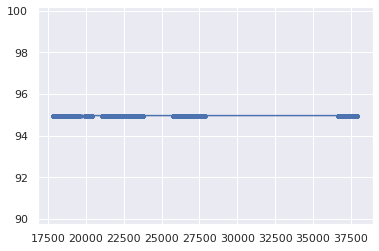

In [14]:
min_cut = 0
max_cut = 10000000
plt.plot(df.run, df.thl_main, 'b.-')
plt.show()

In [16]:
df = df[(df.run<min_cut) | (df.run>max_cut)]

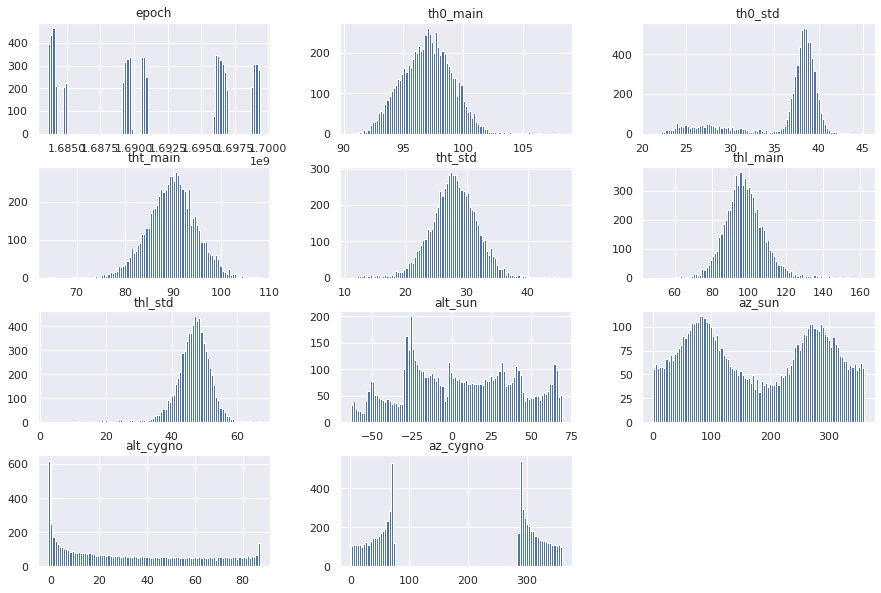

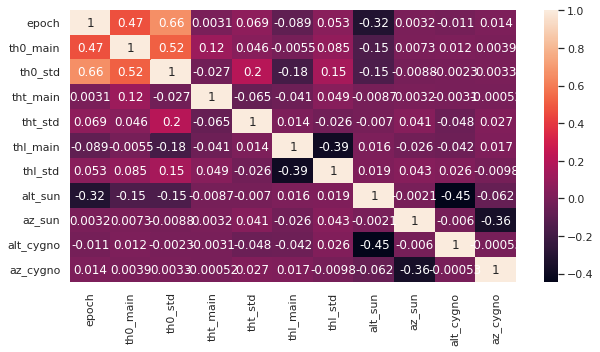

In [54]:
import seaborn as sns
sns.set()

df.hist(bins=100, figsize=(15,10), log=False)
plt.show()

plt.figure(figsize = (10,5))
sns.heatmap(df.corr(), annot=True)
plt.show()

7061
[378.10225182 438.69054011  31.5533053 ]


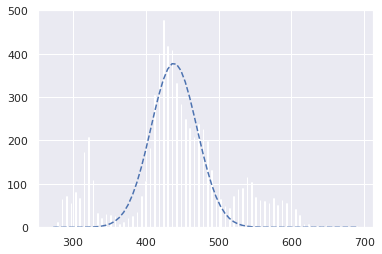

In [55]:

# distanza fra un run e l'altro (in secondi)
bins = 70
upper_limit = 700
y,x = np.histogram(np.gradient(df.epoch)[np.gradient(df.epoch)<upper_limit], bins = bins)
x=x[:-1]
plt.bar(x,y)
popt, pcov = curve_fit(Gauss3,x, y, p0=[140,500, 10])
perr = np.sqrt(np.diag(pcov))
r2=r2_score(y, Gauss3(x, *popt))
print(len(np.gradient(df.epoch)))
plt.plot(x, Gauss3(x, *popt), 'b--')
print(popt)
plt.show()

pick:  1.8976063784801085


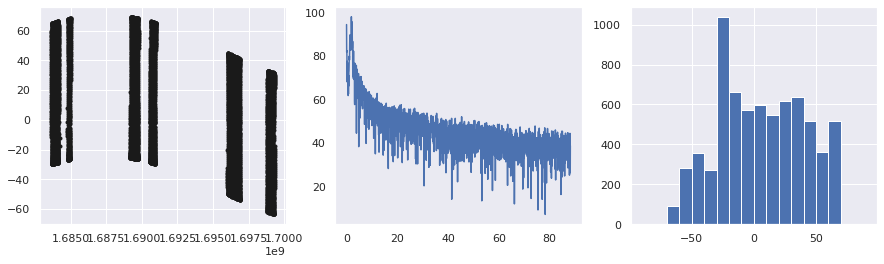

pick:  0.14981102988000855


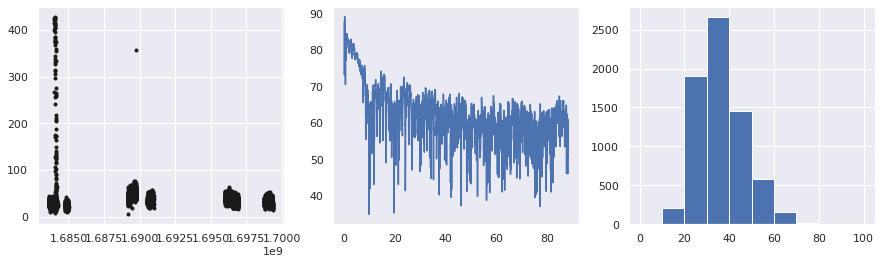

pick:  0.0


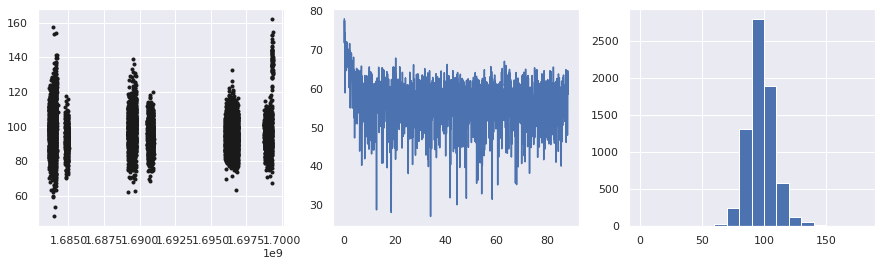

In [56]:
def plt_spectra(y, ax):
    signalFFT = np.fft.rfft(y)
    signalPSD = np.abs(signalFFT) ** 2
    fftFreq = np.fft.fftfreq(len(signalPSD),489.99707781/(24*60*60)) # 494 secondi fra un sample e l'altro 
    i = fftFreq>0
    A = 10*np.log10(signalPSD[i])
    ax.plot(fftFreq[i], A, 'b-')
    ax.grid()
    print("pick: ",fftFreq[np.argmax(A)])
    return ax
fig, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].plot(df.epoch, df.alt_sun, 'k.')
plt_spectra(df.alt_sun, ax[1])
ax[2].hist(df.alt_sun, bins=18, range=(-90, 90))
plt.show()
fig, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].plot(df.epoch, df.rate, 'k.')
plt_spectra(df.rate, ax[1])
ax[2].hist(df.rate, bins=10, range=(0, 100))
plt.show()
fig, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].plot(df.epoch, df.thl_main, 'k.')
plt_spectra(df.thl_main, ax[1])
ax[2].hist(df.thl_main, bins=18, range=(0, 180))
plt.show()
# plt.plot(df.run[(df.run>run_cut) & (df.alt_sun>0)], 
#        df.tht_main[(df.run>run_cut) & (df.alt_sun>0)], 'k.-')
# plt.show()
# plt_spectra(df.tht_main[(df.run>run_cut) & (df.alt_sun>0)])
# plt.plot(df.alt_sun[(df.run>run_cut) & (df.alt_sun>0)], 
#          df.tht_main[(df.run>run_cut) & (df.alt_sun>0)], 'k.')
# plt.show()


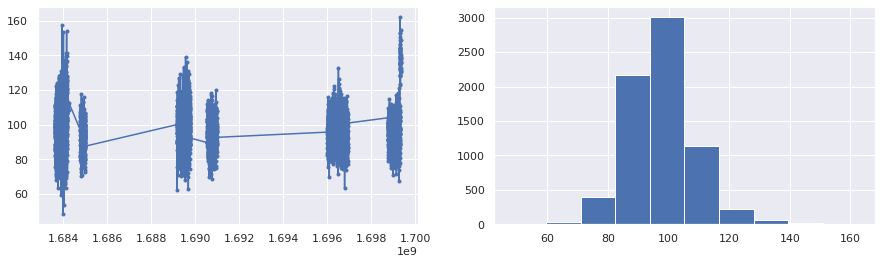

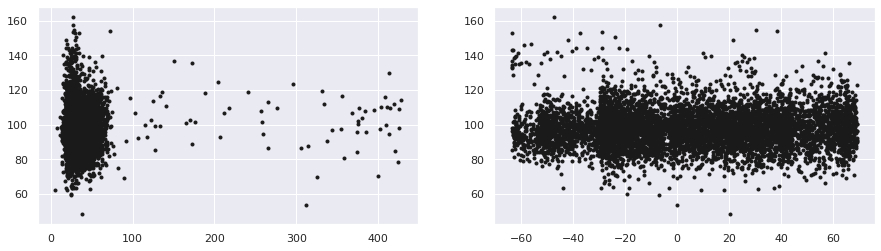

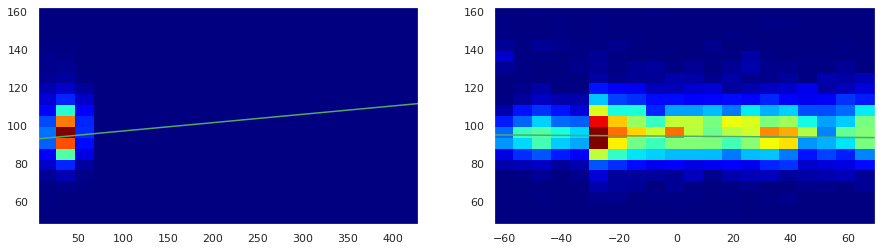

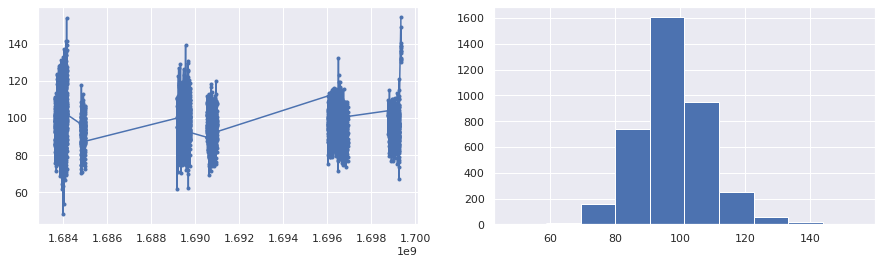

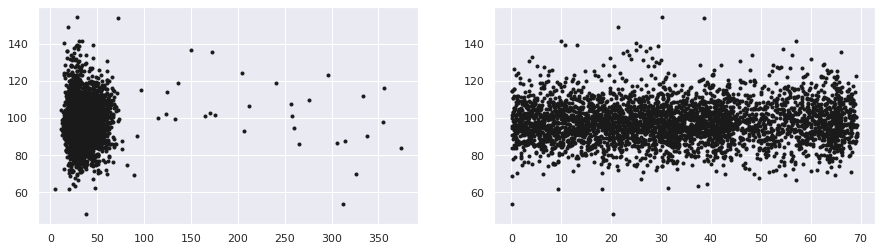

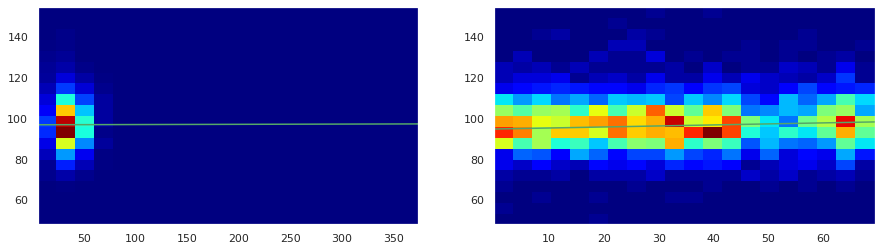

In [57]:

fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(df.epoch, df.thl_main, 'b.-')
ax[1].hist(df.thl_main)
plt.show()
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(df.rate, df.thl_main, 'k.')
ax[1].plot(df.alt_sun, df.thl_main, 'k.')
plt.show()
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].hist2d(df.rate, df.thl_main, bins=(20,20), cmap=plt.cm.jet)
runsac_ply_fit(df.rate, df.thl_main, ax[0], poly_degree = 1)
ax[1].hist2d(df.alt_sun, df.thl_main, bins=(20,20), cmap=plt.cm.jet)
runsac_ply_fit(df.alt_sun, df.thl_main, ax[1], poly_degree = 1)
plt.show()
data_cut = (df.alt_sun>0)
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(df[data_cut].epoch, df[data_cut].thl_main, 'b.-')
ax[1].hist(df[data_cut].thl_main)
plt.show()
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(df[data_cut].rate, df[data_cut].thl_main, 'k.')
ax[1].plot(df[data_cut].alt_sun, df[data_cut].thl_main, 'k.')
plt.show()
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].hist2d(df[data_cut].rate, df[data_cut].thl_main, bins=(20,20), cmap=plt.cm.jet)
runsac_ply_fit(df[data_cut].rate, df[data_cut].thl_main, ax[0], poly_degree = 1)
ax[1].hist2d(df[data_cut].alt_sun, df[data_cut].thl_main, bins=(20,20), cmap=plt.cm.jet)
runsac_ply_fit(df[data_cut].alt_sun, df[data_cut].thl_main, ax[1], poly_degree = 1)
plt.show()

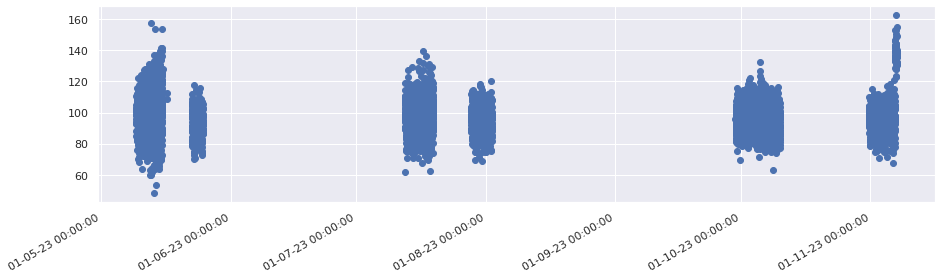

In [58]:
import matplotlib.dates as mdate
secs = mdate.epoch2num(df.epoch)
fig, ax = plt.subplots(figsize=(15,4))

# Plot the date using plot_date rather than plot
ax.plot_date(secs, df.thl_main)

# Choose your xtick format string
date_fmt = '%d-%m-%y %H:%M:%S'

# Use a DateFormatter to set the data to the correct format.
date_formatter = mdate.DateFormatter(date_fmt)
ax.xaxis.set_major_formatter(date_formatter)

# Sets the tick labels diagonal so they fit easier.
fig.autofmt_xdate()

plt.show()

### sigle file debug

In [16]:
run=37707
print(">> date: ", runInfo[runInfo.run_number==run].start_time.values[0])
print(">> info: ", runInfo[runInfo.run_number==run].run_description.values[0])
run_name = '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/'+'reco_run{0:05d}_3D.pkl.gz'.format(run)
dfall=pd.read_pickle(run_name, compression={'method': 'gzip'})
print(dfall.columns)

>> date:  2023-11-06T00:51:28.000000000
>> info:  Standard
Index(['run', 'event', 'pedestal_run', 'cmos_integral', 'cmos_mean',
       'cmos_rms', 't_DBSCAN', 't_variables', 'lp_len', 't_pedsub',
       't_saturation', 't_zerosup', 't_xycut', 't_rebin', 't_medianfilter',
       't_noisered', 'nSc', 'sc_size', 'sc_nhits', 'sc_integral',
       'sc_corrintegral', 'sc_rms', 'sc_energy', 'sc_pathlength',
       'sc_redpixIdx', 'nRedpix', 'redpix_ix', 'redpix_iy', 'redpix_iz',
       'sc_theta', 'sc_length', 'sc_width', 'sc_longrms', 'sc_latrms',
       'sc_lfullrms', 'sc_tfullrms', 'sc_lp0amplitude', 'sc_lp0prominence',
       'sc_lp0fwhm', 'sc_lp0mean', 'sc_tp0fwhm', 'sc_xmean', 'sc_ymean',
       'sc_xmax', 'sc_xmin', 'sc_ymax', 'sc_ymin', 'sc_pearson',
       'sc_tgaussamp', 'sc_tgaussmean', 'sc_tgausssigma', 'sc_tchi2',
       'sc_tstatus', 'sc_lgaussamp', 'sc_lgaussmean', 'sc_lgausssigma',
       'sc_lchi2', 'sc_lstatus', 'Lime_pressure', 'Atm_pressure',
       'Lime_temperature', 'At

In [19]:
dfall.t_rebin

0      0.026925
1      0.026719
2      0.060175
3      0.042539
4      0.027364
         ...   
398    0.026181
399    0.026323
400    0.026291
401    0.026808
402    0.026110
Name: t_rebin, Length: 403, dtype: float32

dict

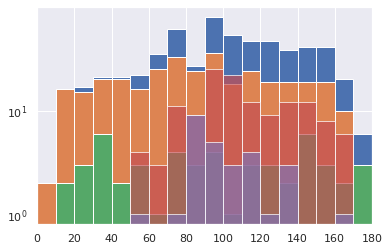

In [24]:
plt.hist(np.array(data['th0']),bins=18,range=(0,180))
plt.hist(np.array(data['thf']),bins=18,range=(0,180))
plt.hist(np.array(data['tht2']),bins=18,range=(0,180))
plt.hist(np.array(data['thg']),bins=18,range=(0,180), alpha = 0.7)
plt.hist(np.array(data['tht']),bins=18,range=(0,180), alpha = 0.7)
plt.xlim(0,180)

plt.yscale('Log')
plt.show()

In [12]:
l2 = np.sqrt((np.hstack(dfall.sc_xmax)-np.hstack(dfall.sc_xmin))**2+
             (np.hstack(dfall.sc_ymax)-np.hstack(dfall.sc_ymin))**2)
#m = (np.hstack(dfall.sc_ymax)-np.hstack(dfall.sc_ymin))/(np.hstack(dfall.sc_xmax)-np.hstack(dfall.sc_xmin))
th0 = 360*np.arctan2((np.hstack(dfall.sc_ymax)-
                      np.hstack(dfall.sc_ymin)), 
                     (np.hstack(dfall.sc_xmax)-
                      np.hstack(dfall.sc_xmin)))/np.pi
fake_cut = (np.hstack(dfall.sc_rms)>6) & (0.152 * np.hstack(dfall.sc_tgausssigma) > 0.5) \
            & (np.hstack(dfall.sc_integral) > 1000)
geo_cut = (np.hstack(dfall.sc_xmin)>400) & (np.hstack(dfall.sc_xmax)<1900) \
           & (np.hstack(dfall.sc_ymax)<1900) & (np.hstack(dfall.sc_ymin)>400)
thf = 360*np.arctan2((np.hstack(dfall.sc_ymax)[fake_cut]-
                      np.hstack(dfall.sc_ymin)[fake_cut]), 
                     (np.hstack(dfall.sc_xmax)[fake_cut]-
                      np.hstack(dfall.sc_xmin)[fake_cut]))/np.pi
thg = 360*np.arctan2((np.hstack(dfall.sc_ymax)[geo_cut]-
                      np.hstack(dfall.sc_ymin)[geo_cut]), 
                     (np.hstack(dfall.sc_xmax)[geo_cut]-
                      np.hstack(dfall.sc_xmin)[geo_cut]))/np.pi
tht = 360*np.arctan2((np.hstack(dfall.sc_ymax)[fake_cut & geo_cut]-
                      np.hstack(dfall.sc_ymin)[fake_cut & geo_cut]), 
                     (np.hstack(dfall.sc_xmax)[fake_cut & geo_cut]-
                      np.hstack(dfall.sc_xmin)[fake_cut & geo_cut]))/np.pi
tht2 = 360*np.arctan2((np.hstack(dfall.sc_ymax)[fake_cut & (np.hstack(dfall.sc_length)>1700)]-
                       np.hstack(dfall.sc_ymin)[fake_cut & (np.hstack(dfall.sc_length)>1700)]), 
                      (np.hstack(dfall.sc_xmax)[fake_cut & (np.hstack(dfall.sc_length)>1700)]-
                       np.hstack(dfall.sc_xmin)[fake_cut & (np.hstack(dfall.sc_length)>1700)]))/np.pi

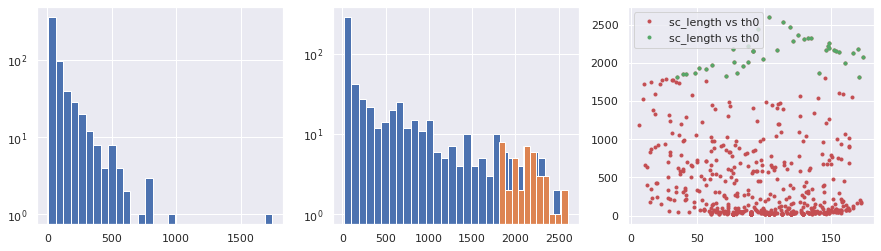

In [13]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].hist(np.hstack(dfall.sc_width), 30, log=True, label='sc_width')
ax[1].hist(np.hstack(dfall.sc_length), 30, log=True, label='sc_length')
ax[1].hist(np.hstack(dfall.sc_length)[np.hstack(dfall.sc_length)>1800], 11, log=True)
ax[2].plot(th0, np.hstack(dfall.sc_length), 'r.', label='sc_length vs th0')
ax[2].plot(th0[(np.hstack(dfall.sc_length)>1800) & (fake_cut)], 
           np.hstack(dfall.sc_length)[(np.hstack(dfall.sc_length)>1800) & (fake_cut)], 
           'g.', label='sc_length vs th0')
plt.legend()
plt.show()

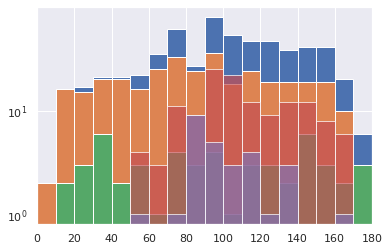

In [14]:
plt.hist(th0,bins=18,range=(0,180))
plt.hist(thf,bins=18,range=(0,180))
plt.hist(tht2,bins=18,range=(0,180))
plt.hist(thg,bins=18,range=(0,180), alpha = 0.7)
plt.hist(tht,bins=18,range=(0,180), alpha = 0.7)
plt.xlim(0,180)

plt.yscale('Log')
plt.show()

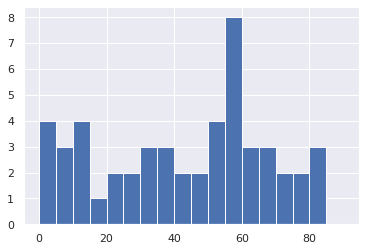

In [15]:
plt.hist(abs(90-tht2),18,range=(0,90))
plt.show()

### general debug and tests

In [27]:
int(10*len(th0))

84360

In [28]:
180/18

10.0

In [75]:
x = np.linspace(0,10*3.14,1000)
n = np.random.normal(0, 0.1, 1000)
#n = np.random.rand(1,1000)[0]
y = np.sin(x+n)
f = np.fft.rfft(y)
sample = len(x)
sample_freq = 1 # esempio 1 sample ogni 1 secondi
r = np.fft.rfftfreq(len(x), 1/sample_freq)

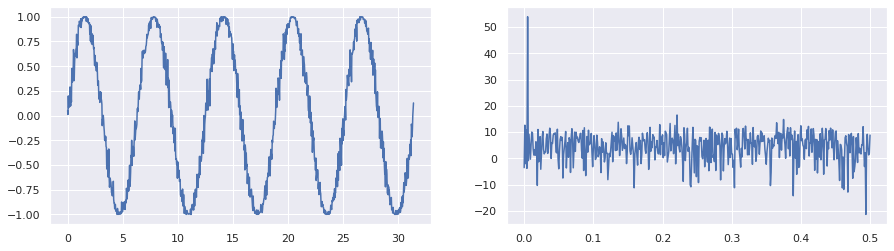

In [76]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(x,y)
ax[1].plot(r,10*np.log10(np.abs(f)**2))
plt.show()

In [32]:
def runsac_ply_fit(x_values, y_values, ax, poly_degree = 1):

    from sklearn.linear_model import (
        LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
    #
    # different regression method can be apply 
    # see https://scikit-learn.org/stable/auto_examples/linear_model/plot_robust_fit.html#sphx-glr-auto-examples-linear-model-plot-robust-fit-py
    # see below
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline

#    plt.plot(x_values, y_values, 'r.')
    x_plot = np.linspace(x_values.min(), x_values.max())
    X = np.array(x_values)[:, np.newaxis]

    model = make_pipeline(PolynomialFeatures(poly_degree), RANSACRegressor(min_samples=2,
                                                                           residual_threshold=2,
                                                                           max_trials=1000,
                                                                           random_state=42))
    model.fit(X, y_values)
    mse = mean_squared_error(model.predict(X), y_values)

    y_plot = model.predict(x_plot[:, np.newaxis])
    ax.plot(x_plot, y_plot, 'g-', label='error = %.3f' % (mse))
#    ax.legend()
    return ax


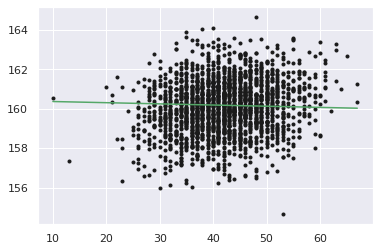

In [33]:
fig,ax = plt.subplots()
ax.plot(df.rate, df.thl_main, 'k.')
runsac_ply_fit(df.rate, df.thl_main, ax, poly_degree = 1)
plt.show()

In [75]:
import numpy as np
import uproot
import pandas as pd
import cygno as cy
import os
# variable to pass
start_run=37707
end_run=37707
run_description = 'Standard'
reco_path0 = 'Winter23-ReReco-Run3/'
rebuild = False
# debug
verbose = False
run_description = None
# 
file_out_path = '/jupyter-workspace/cloud-storage/cygno-analysis/pkl2/'
BASE_URL = 'https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/'
reco_path = BASE_URL+'cygno-analysis/RECO/'+reco_path0
try:
    runInfo=cy.read_cygno_logbook(sql=True,verbose=verbose)
    if verbose: print(runInfo)
except Exception as e:
    print('ERROR >>> {}'.format(e))

#runSel = runInfo.loc[runInfo.run_description.str.contains('Stability')]
if run_description:
    runSel = runInfo.loc[runInfo.run_description == run_description]
else:
    runSel = runInfo


for i, run in enumerate(runSel[(runInfo.run_number>=start_run) & 
                               (runInfo.run_number<=end_run)].run_number):

    if (runSel[runSel.run_number==run].online_reco_status.values[0]==1 and 
       runSel[runSel.run_number==run].pedestal_run.values[0]==0):

        print("analyzing run: ",run, str(runSel[runSel.run_number==run].run_description.values))

        #
        # caricamento o creazione del file plk
        #
        file_out_name = file_out_path+'reco_run{0:05d}_3D.pkl.gz'.format(run)
        if os.path.isfile(file_out_name) and (not rebuild):
            dfe=pd.read_pickle(file_out_name)

        else:
            try:
                branch_data = {}
                file_url = reco_path+'reco_run{:5d}_3D.root'.format(run)
                tf = uproot.open(file_url)
                names = tf["Events;1"].keys()
                for i, name in enumerate(names):
                    var = tf["Events;1/"+name].array(library="np")
                    if var[0].ndim == 0:
                        branch_data[name] = np.hstack(var)
                    else:
                    #     vara = []
                    #     for j, va in enumerate(var):
                    #         vara.append(va)
                    #     branch_data[name] = vara
                        branch_data[name] = var
                df = pd.DataFrame(branch_data)
                df.to_pickle(file_out_name, compression={'method': 'gzip', 'compresslevel': 1})
            except Exception as e:
                print('ERROR >>> {}'.format(e))
                continue

print("DONE")

analyzing run:  37707 ['Standard']
DONE


In [3]:
run=37859
#run=43742

try:
    runInfo[runInfo.run_number==run].start_time.values[0]
except:
    runInfo=cy.read_cygno_logbook(sql=True)
print(">> date: ", runInfo[runInfo.run_number==run].start_time.values[0])
print(">> info: ", runInfo[runInfo.run_number==run].run_description.values[0])
print(">> source: ", runInfo[runInfo.run_number==run].source_type.values[0])
print(">> source: ", runInfo[runInfo.run_number==run].source_position.values[0])
run_name = '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/'+'reco_run{0:05d}_3D.pkl.gz'.format(run)
dfall=pd.read_pickle(run_name, compression={'method': 'gzip'})
print(dfall.columns)

>> date:  2023-11-06T19:38:49.000000000
>> info:  Standard
>> source:  0.0
>> source:  0.0
Index(['run', 'event', 'pedestal_run', 'cmos_integral', 'cmos_mean',
       'cmos_rms', 't_DBSCAN', 't_variables', 'lp_len', 't_pedsub',
       't_saturation', 't_zerosup', 't_xycut', 't_rebin', 't_medianfilter',
       't_noisered', 'nSc', 'sc_size', 'sc_nhits', 'sc_integral',
       'sc_corrintegral', 'sc_rms', 'sc_energy', 'sc_pathlength',
       'sc_redpixIdx', 'nRedpix', 'redpix_ix', 'redpix_iy', 'redpix_iz',
       'sc_theta', 'sc_length', 'sc_width', 'sc_longrms', 'sc_latrms',
       'sc_lfullrms', 'sc_tfullrms', 'sc_lp0amplitude', 'sc_lp0prominence',
       'sc_lp0fwhm', 'sc_lp0mean', 'sc_tp0fwhm', 'sc_xmean', 'sc_ymean',
       'sc_xmax', 'sc_xmin', 'sc_ymax', 'sc_ymin', 'sc_pearson',
       'sc_tgaussamp', 'sc_tgaussmean', 'sc_tgausssigma', 'sc_tchi2',
       'sc_tstatus', 'sc_lgaussamp', 'sc_lgaussmean', 'sc_lgausssigma',
       'sc_lchi2', 'sc_lstatus', 'Lime_pressure', 'Atm_pressure'

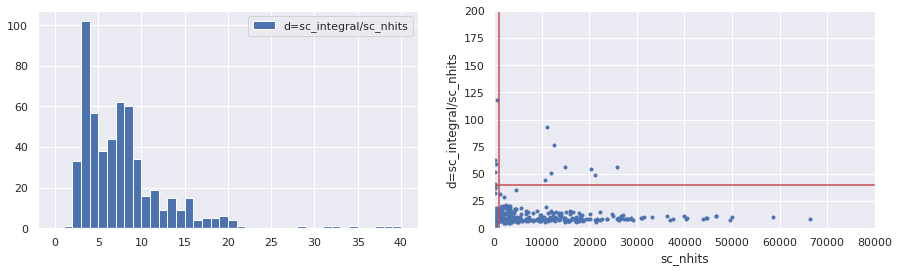

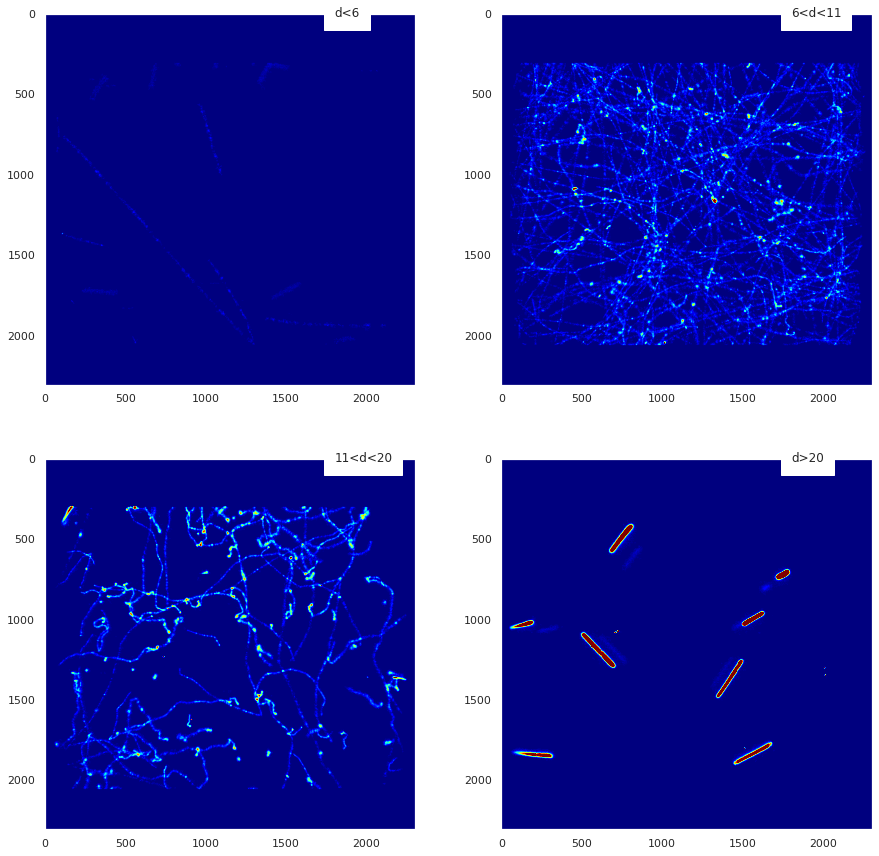

ValueError: Item wrong length 559 instead of 401.

In [5]:
def fill_by_density(dfall, xmax=20):
    data_to_save = {}
    imageA = np.zeros((2304, 2304), dtype=np.int64)
    imageB = np.zeros((2304, 2304), dtype=np.int64)
    imageC = np.zeros((2304, 2304), dtype=np.int64)
    imageD = np.zeros((2304, 2304), dtype=np.int64)
    x_varA = []
    y_varA = []
    x_varB = []
    y_varB = []
    x_varC = []
    y_varC = []
    x_varD = []
    y_varD = []
    cut = dfall.sc_integral/dfall.sc_nhits
    for i, Sc in enumerate(dfall.nSc):
        for j, val in enumerate(cut[i]):
            if j == len(cut[i])-1:
                jmax = int(len(dfall.redpix_ix[i]))
            else:
                jmax = int(dfall.sc_redpixIdx[i][j+1])
            if val>=xmax : #and (dfall.sc_nhits[i][j]>1000)
                if j == len(cut[i])-1:
                    jmax = int(len(dfall.redpix_ix[i]))
                else:
                    jmax = int(dfall.sc_redpixIdx[i][j+1])
                # print (dfall.sc_nhits[i][j])
                imageD[dfall.redpix_ix[i][int(dfall.sc_redpixIdx[i][j]):jmax], 
                      dfall.redpix_iy[i][int(dfall.sc_redpixIdx[i][j]):jmax]]=\
                imageD[dfall.redpix_ix[i][int(dfall.sc_redpixIdx[i][j]):jmax], 
                      dfall.redpix_iy[i][int(dfall.sc_redpixIdx[i][j]):jmax]]+\
                dfall.redpix_iz[i][int(dfall.sc_redpixIdx[i][j]):jmax]
                x_varD.append(int(dfall.sc_xmean[i][j]))
                y_varD.append(int(dfall.sc_ymean[i][j]))
            elif val>=11 and val<xmax:
                imageC[dfall.redpix_ix[i][int(dfall.sc_redpixIdx[i][j]):jmax], 
                      dfall.redpix_iy[i][int(dfall.sc_redpixIdx[i][j]):jmax]]=\
                imageC[dfall.redpix_ix[i][int(dfall.sc_redpixIdx[i][j]):jmax], 
                      dfall.redpix_iy[i][int(dfall.sc_redpixIdx[i][j]):jmax]]+\
                dfall.redpix_iz[i][int(dfall.sc_redpixIdx[i][j]):jmax]
                x_varC.append(int(dfall.sc_xmean[i][j]))
                y_varC.append(int(dfall.sc_ymean[i][j]))
            elif val>=6 and val<11:
                imageB[dfall.redpix_ix[i][int(dfall.sc_redpixIdx[i][j]):jmax], 
                      dfall.redpix_iy[i][int(dfall.sc_redpixIdx[i][j]):jmax]]=\
                imageB[dfall.redpix_ix[i][int(dfall.sc_redpixIdx[i][j]):jmax], 
                      dfall.redpix_iy[i][int(dfall.sc_redpixIdx[i][j]):jmax]]+\
                dfall.redpix_iz[i][int(dfall.sc_redpixIdx[i][j]):jmax]   
                x_varB.append(int(dfall.sc_xmean[i][j]))
                y_varB.append(int(dfall.sc_ymean[i][j]))
            elif val<6:
                imageA[dfall.redpix_ix[i][int(dfall.sc_redpixIdx[i][j]):jmax], 
                      dfall.redpix_iy[i][int(dfall.sc_redpixIdx[i][j]):jmax]]=\
                imageA[dfall.redpix_ix[i][int(dfall.sc_redpixIdx[i][j]):jmax], 
                      dfall.redpix_iy[i][int(dfall.sc_redpixIdx[i][j]):jmax]]+\
                dfall.redpix_iz[i][int(dfall.sc_redpixIdx[i][j]):jmax] 
                x_varA.append(int(dfall.sc_xmean[i][j]))
                y_varA.append(int(dfall.sc_ymean[i][j]))
    data_to_save['imageA']=[imageA]
    data_to_save['imageB']=[imageB]
    data_to_save['imageC']=[imageC]
    data_to_save['imageD']=[imageD]
    data_to_save['x_varA']=[x_varA]
    data_to_save['y_varA']=[y_varA]
    data_to_save['x_varB']=[x_varB]
    data_to_save['y_varB']=[y_varB]
    data_to_save['x_varC']=[x_varC]
    data_to_save['y_varC']=[y_varC]
    data_to_save['x_varD']=[x_varD]
    data_to_save['y_varD']=[y_varD]
    df = pd.DataFrame(data_to_save, index=[0])
    return df
def plot_by_density2(dfrun, xmax=20):
    fig, ax = plt.subplots(2,2, figsize=(15,15))
    imageA = dfrun.imageA[0]
    imageB = dfrun.imageB[0]
    imageC = dfrun.imageC[0]
    imageD = dfrun.imageD[0]
    ax[0,0].imshow(imageA, vmin=0, vmax=100, cmap='jet', )
    ax[0,1].imshow(imageB, vmin=0, vmax=100, cmap='jet', )
    ax[1,0].imshow(imageC, vmin=0, vmax=100, cmap='jet', )
    ax[1,1].imshow(imageD, vmin=0, vmax=100, cmap='jet', )
    ax[0,0].text(1800, 20, 'd<6', bbox={'facecolor': 'white', 'pad': 10})
    ax[0,1].text(1800, 20, '6<d<11', bbox={'facecolor': 'white', 'pad': 10})
    ax[1,0].text(1800, 20, '11<d<{:d}'.format(xmax), bbox={'facecolor': 'white', 'pad': 10})
    ax[1,1].text(1800, 20, 'd>{:d}'.format(xmax), bbox={'facecolor': 'white', 'pad': 10})
    ax[0,0].grid(None)
    ax[0,1].grid(None)
    ax[1,0].grid(None)
    ax[1,1].grid(None)
    plt.show()

def plot_by_density(dfall, xmax=20):
    fig, ax = plt.subplots(1,2, figsize=(15,4))
    ax[0].hist(np.hstack(dfall.sc_integral/dfall.sc_nhits), bins=40, range=(0, xmax), label='d=sc_integral/sc_nhits')
    ax[0].legend()
    ax[1].plot(np.hstack(dfall.sc_nhits), np.hstack(dfall.sc_integral/dfall.sc_nhits), 'b.')
    ax[1].axhline(xmax, color='r')
    ax[1].axvline(1000, color='r')
    ax[1].set_ylim(0,200)
    ax[1].set_xlim(0,80000)
    ax[1].set_xlabel('sc_nhits')
    ax[1].set_ylabel('d=sc_integral/sc_nhits')
    plt.show()
    
    dfrun = fill_by_density(dfall, xmax)
    plot_by_density2(dfrun)

def fill_image(df):
    image = np.zeros((2304, 2304), dtype=np.int64)
    for i, event in enumerate(df.event):

        image[df.redpix_ix[event], df.redpix_iy[event]]= \
        image[df.redpix_ix[event], df.redpix_iy[event]] + df.redpix_iz[event]
    return image
def alpha_rate(dfall, xmax=20):
    geo_cut = (np.hstack(dfall.sc_xmin)>400) & (np.hstack(dfall.sc_xmax)<1900) \
               & (np.hstack(dfall.sc_ymax)<2200) & (np.hstack(dfall.sc_ymin)>100)
    cut = dfall.sc_integral/dfall.sc_nhits
    cutg = dfall[geo_cut].sc_integral/dfall[geo_cut].sc_nhits
    nalpha = 0
    for i in range(len(cut)):
        nalpha +=len(cut[i][(cut[i]>40) & (dfall.sc_length[i]>50)])
        nalphag +=len(cutg[i][(cutg[i]>40) & (dfall.sc_length[i]>50)])
    return nalpha, nalphag
plot_by_density(dfall, xmax=40)
alpha_rate(dfall, xmax=40)

In [12]:
cut = dfall.sc_integral/dfall.sc_nhits
geo_cut = (dfall.sc_xmin>400) & (dfall.sc_xmax<1900) & (dfall.sc_ymax<2200) & (dfall.sc_ymin>100)
dfallgeo = dfall[geo_cut]
nalpha = 0
for i in range(len(cut)):
    nalpha +=len(cut[i][(cut[i]>40) & (dfall.sc_length[i]>50)])
print(nalpha)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [41]:
dfall.sc_length[i]

array([1291.262   ,  273.3151  ,   73.620544], dtype=float32)

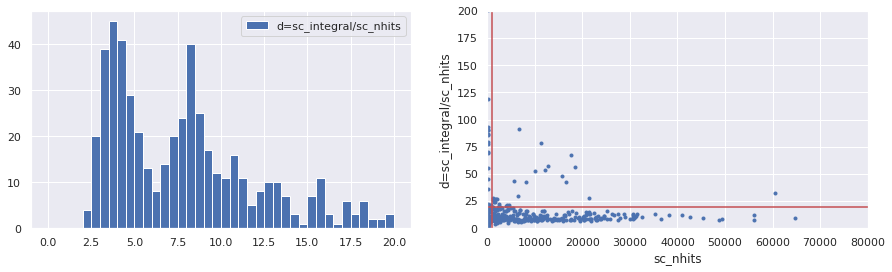

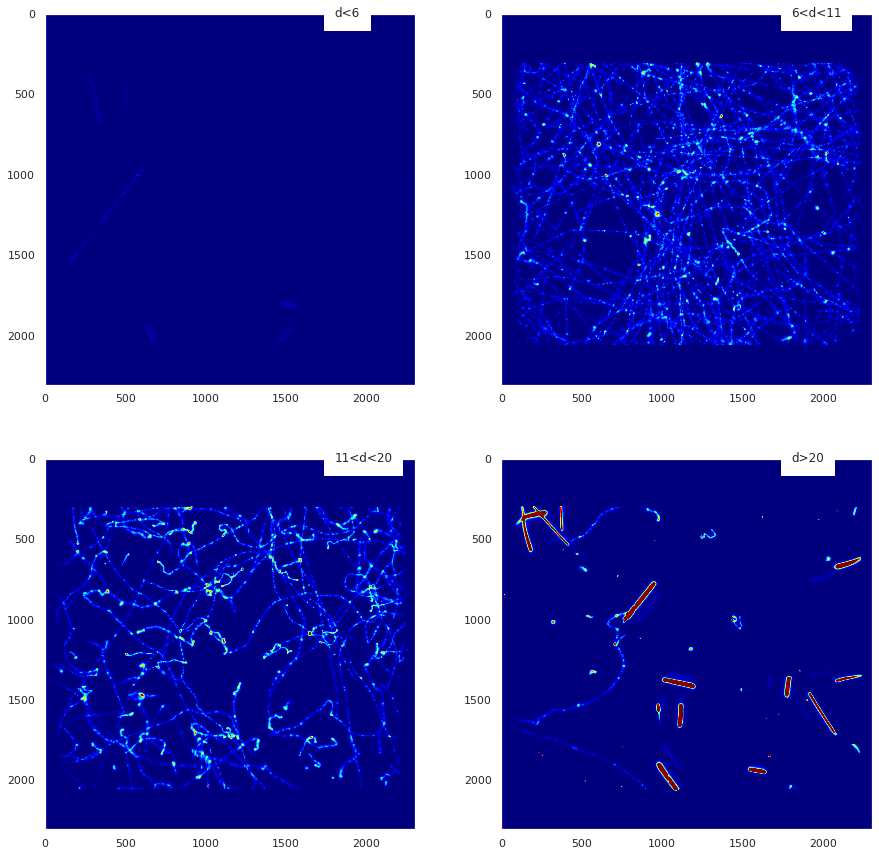

In [5]:
import numpy as np
import pandas as pd
import cygno as cy
import os
image = np.zeros((2304, 2304), dtype=np.int64)
x_var = []
y_var = []
data_to_save = {}
runInfo=cy.read_cygno_logbook(sql=True)
run=44396
force = True
if runInfo[runInfo.run_number==run].source_type.values[0]==0 or force:
    run_name = '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/'+'reco_run{0:05d}_3D.pkl.gz'.format(run)
    dfall=pd.read_pickle(run_name, compression={'method': 'gzip'})
    plot_by_density(dfall)


In [5]:
image = np.zeros((2304, 2304), dtype=np.int64)
x_var = []
y_var = []
#for run in range(43515, 43742):
#runInfo=cy.read_cygno_logbook(sql=True)
data_to_save = {}
first = True
#for i, run in enumerate(runInfo.run_number):
for run in range(17362, 39638):
    try:
        if runInfo[runInfo.run_number==run].source_type.values[0]==0:
            print(i, run)
            run_name = '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/'+'reco_run{0:05d}_3D.pkl.gz'.format(run)
            dfall=pd.read_pickle(run_name, compression={'method': 'gzip'})
            dfraw = fill_by_density(dfall)
            if first:
                dfsave = dfraw
                first = False
            else:
                dfsave = dfsave+dfraw
                        
    except Exception as e:
        print("ped file", e)


30930 36665
30931 36666
30932 36667
30933 36668
30934 36669
30935 36670
30936 36671
30937 36672
30938 36673
30939 36674
30940 36675
ped file [Errno 2] No such file or directory: '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/reco_run36675_3D.pkl.gz'
30941 36676
30942 36677
ped file [Errno 2] No such file or directory: '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/reco_run36677_3D.pkl.gz'
30943 36678
30944 36679
ped file [Errno 2] No such file or directory: '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/reco_run36679_3D.pkl.gz'
30945 36680
30946 36681
30947 36682
30948 36683
30949 36684
30950 36685
30951 36686
ped file [Errno 2] No such file or directory: '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/reco_run36686_3D.pkl.gz'
30952 36687
30953 36688
30954 36689
ped file [Errno 2] No such file or directory: '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/reco_run36689_3D.pkl.gz'
30955 36690
30956 36691
ped file [Errno 2] No such file or directory: '/jupyter-

In [6]:
file_out_name = '/jupyter-workspace/cloud-storage/cygno-analysis/out/gmout_alpha2.pkl.gz'
dfsave.to_pickle(file_out_name, compression={'method': 'gzip', 'compresslevel': 1})

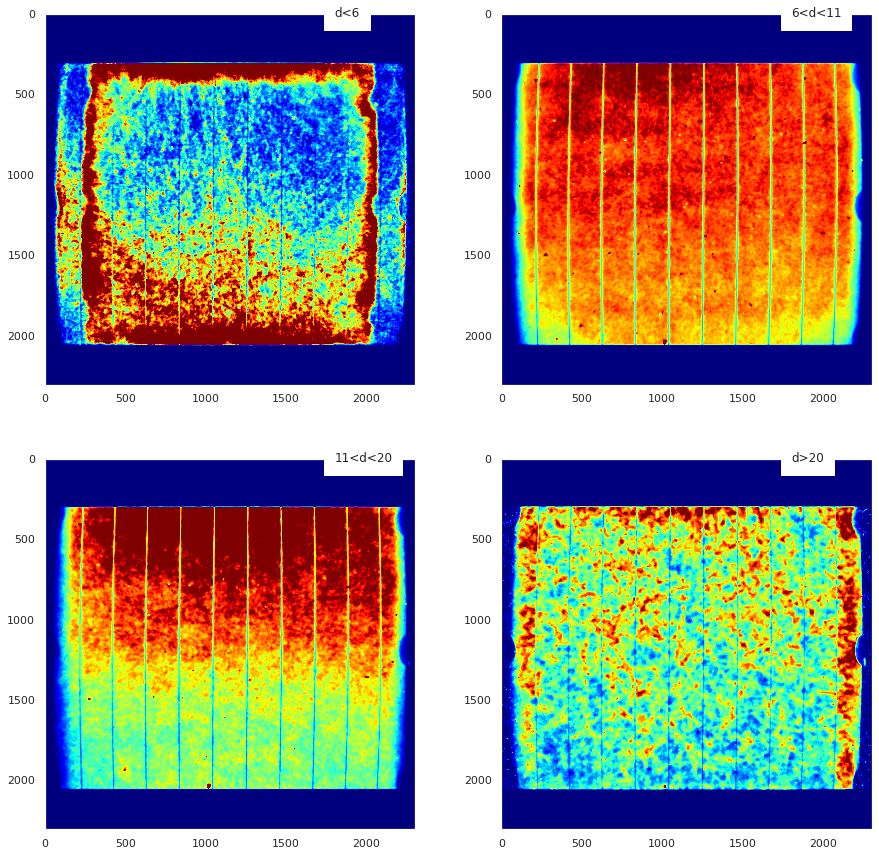

In [19]:
def plot_by_density3(dfrun):
    fig, ax = plt.subplots(2,2, figsize=(15,15))
    imageA = dfrun.imageA[0]
    imageB = dfrun.imageB[0]
    imageC = dfrun.imageC[0]
    imageD = dfrun.imageD[0]
    ax[0,0].imshow(imageA, vmin=0, vmax=100, cmap='jet', )
    ax[0,1].imshow(imageB, vmin=0, vmax=8000, cmap='jet', )
    ax[1,0].imshow(imageC, vmin=0, vmax=4500, cmap='jet', )
    ax[1,1].imshow(imageD, vmin=0, vmax=4500, cmap='jet', )
    ax[0,0].text(1800, 20, 'd<6', bbox={'facecolor': 'white', 'pad': 10})
    ax[0,1].text(1800, 20, '6<d<11', bbox={'facecolor': 'white', 'pad': 10})
    ax[1,0].text(1800, 20, '11<d<20', bbox={'facecolor': 'white', 'pad': 10})
    ax[1,1].text(1800, 20, 'd>20', bbox={'facecolor': 'white', 'pad': 10})
    ax[0,0].grid(None)
    ax[0,1].grid(None)
    ax[1,0].grid(None)
    ax[1,1].grid(None)
    plt.show()
plot_by_density3(dfsave)

In [98]:
file_out_name = '/jupyter-workspace/cloud-storage/cygno-analysis/out/gmout.pkl.gz'
#file_out_name = '/jupyter-workspace/cloud-storage/cygno-analysis/out/gmout_no_alpha.pkl.gz'
dfi=pd.read_pickle(file_out_name, compression={'method': 'gzip'})
print(dfi.columns)
image = dfi['image'][0]
x_var = dfi['x_var'][0]
y_var = dfi['y_var'][0]

Index(['image', 'x_var', 'y_var'], dtype='object')


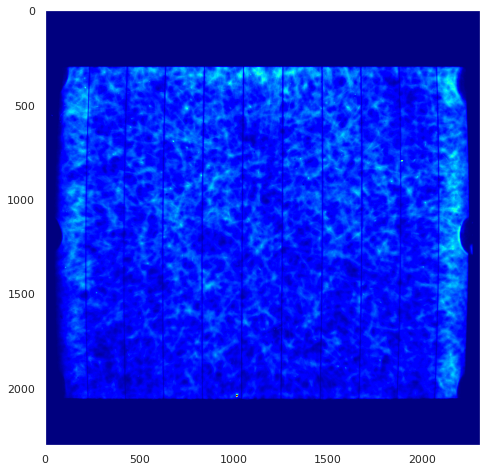

In [99]:
plt.figure(figsize=(8,8))
plt.imshow(image, vmin=0, vmax=15000, cmap='jet')
plt.grid(None)
plt.show()

In [80]:
image2 = cy.rebin(image, (144,144))

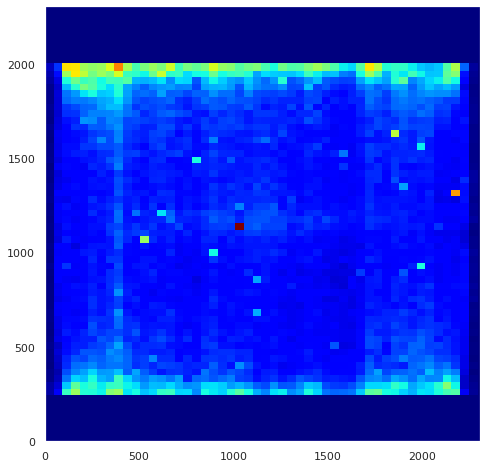

In [97]:
image_bck = np.zeros((2304, 2304), dtype=np.int64)
plt.figure(figsize=(8,8))
plt.imshow(image_bck, vmin=0, vmax=1, cmap='jet')
plt.hist2d(np.array(y_var), 2304-np.array(x_var), bins=(50,50), cmap=plt.cm.jet, cmin=0, cmax=1500)
plt.xlim(0,2304)
plt.ylim(0,2304)
plt.show()

/usr/local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


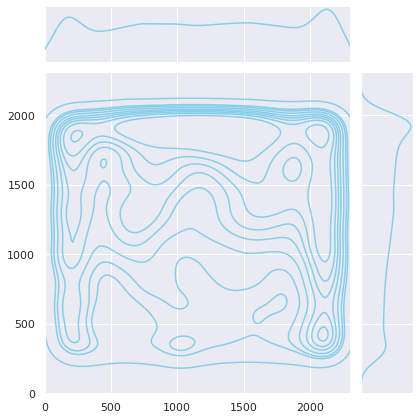

In [100]:
import seaborn as sns
#sns.set(style="white", color_codes=True)
sns.jointplot(np.array(y_var),(2304-np.array(x_var)), kind='kde', color="skyblue", xlim=(0,2304), ylim=(0,2304))

plt.show()

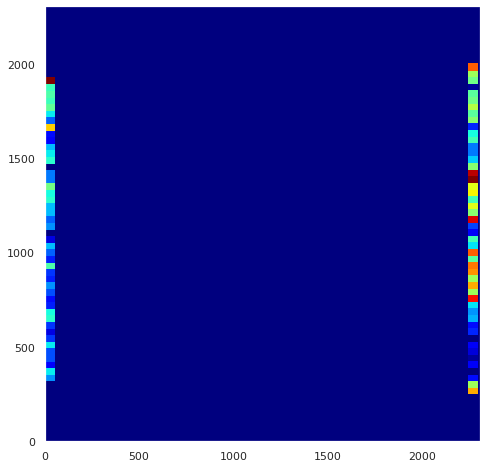

In [83]:
image_bck = np.zeros((2304, 2304), dtype=np.int64)
plt.figure(figsize=(8,8))
plt.imshow(image_bck, vmin=0, vmax=1, cmap='jet')
xp = np.array(y_var)
yp = 2304-np.array(x_var)
cut_pixel = 250
plt.hist2d(xp[xp<cut_pixel], yp[xp<cut_pixel], bins=(5,50), cmap=plt.cm.jet, cmin=0, cmax=50)
plt.hist2d(xp[xp>(2304-cut_pixel)], yp[xp>(2304-cut_pixel)], bins=(5,50), cmap=plt.cm.jet, cmin=0, cmax=50)
plt.xlim(0,2304)
plt.ylim(0,2304)
plt.show()

In [84]:
len(image)

2304

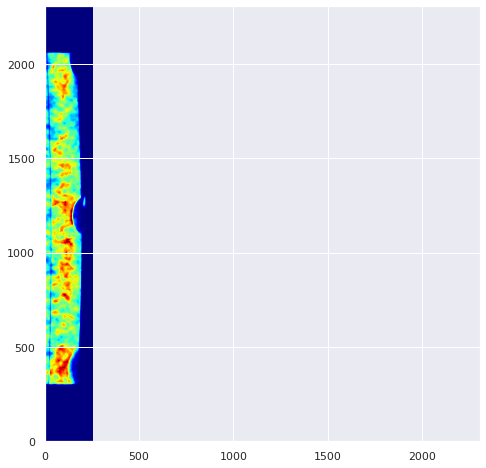

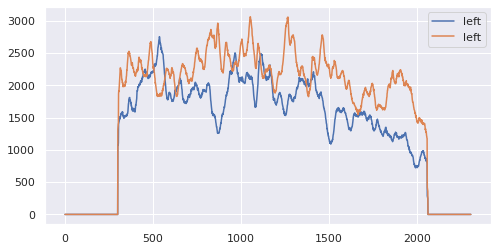

In [101]:
image_bck = np.zeros((2304, 2304), dtype=np.int64)
plt.figure(figsize=(8,8))
#plt.imshow(image_bck, vmin=0, vmax=1, cmap='jet')
xp = np.array(y_var)
yp = 2304-np.array(x_var)
cut_pixel = 250
plt.imshow(image[:, 0:cut_pixel], vmin=0, vmax=6000, cmap='jet')
plt.imshow(image[:, 2304-cut_pixel:], vmin=0, vmax=6000, cmap='jet')
#plt.hist2d(xp[xp<cut_pixel], yp[xp<cut_pixel], bins=(5,50), cmap=plt.cm.jet, cmin=0, cmax=50)
#plt.hist2d(xp[xp>(2304-cut_pixel)], yp[xp>(2304-cut_pixel)], bins=(5,50), cmap=plt.cm.jet, cmin=0, cmax=50)
plt.xlim(0,2304)
plt.ylim(0,2304)
plt.show()
plt.figure(figsize=(8,4))
Xproj      = np.mean(image[:, 0:cut_pixel], axis=0)
Yproj      = np.mean(image[:, 0:cut_pixel], axis=1)
plt.plot(np.linspace(0, len(image), len(image)), Yproj, label='left')
Xproj      = np.mean(image[:, 2304-cut_pixel:], axis=0)
Yproj      = np.mean(image[:, 2304-cut_pixel:], axis=1)
plt.plot(np.linspace(0, len(image), len(image)), Yproj, label='left')
plt.legend()
plt.show()

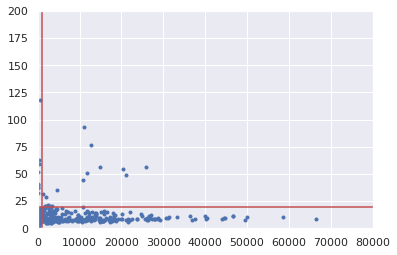

In [120]:
plt.plot(np.hstack(dfall.sc_nhits), np.hstack(dfall.sc_integral/dfall.sc_nhits), 'b.')
plt.axhline(20, color='r')
plt.axvline(1000, color='r')
plt.ylim(0,200)
plt.xlim(0,80000)

plt.show()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

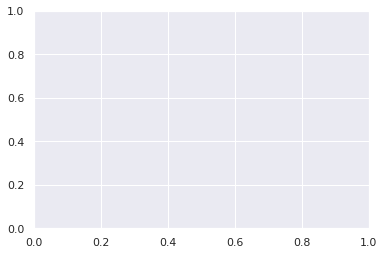

In [137]:
def Gauss3(x, a0, x0, s0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))

def plt_hist(data, xmin=4000, xmax=14000, bins=50, verbose=False):
    import matplotlib.pyplot as plt
    import base64
    from json import dump
    import numpy as np
    import seaborn as sns
    from scipy.optimize import curve_fit

    stat = data[(data>xmin) & (data<xmax)].mean(), data[(data>xmin) & (data<xmax)].std()
    fig,ax = plt.subplots()
    
    y,x = np.histogram(data, range=(xmin,xmax), bins = bins)
    x=x[:-1]
    w = abs(x[1] - x[0])
    xfmin=stat[0]-0.4*stat[1]
    xfmax=stat[0]+3*stat[1]
    popt, pcov = curve_fit(Gauss3,x[(x>xfmin) & (x<xfmax)], y[(x>xfmin) & (x<xfmax)], 
                           p0=[500, stat[0], stat[1]])
    perr = np.sqrt(np.diag(pcov))
    ax.bar(x,y, width=w, label='run{}\nmean: {:.1f}\nstd: {:.1f}'.format(run,stat[0], stat[1]))
    #ax.hist(data, bins=bins, range=(xmin,xmax), label='run{}\nmean: {:.1f}\nstd: {:.1f}'.format(run,stat[0], stat[1]))
    ax.plot(x[(x>xfmin) & (x<xfmax)], Gauss3(x[(x>xfmin) & (x<xfmax)], *popt), 'r--', 
            label='p0 = {:.1f}+/-{:.1f}\np1 = {:.1f}+/-{:.1f}\np3 = {:.1f}+/-{:.1f}'\
            .format(popt[0],perr[0],popt[1],perr[1],popt[2],perr[2]))
    
    ax.legend()
    plt.savefig('/tmp/fe.png')
    if verbose: plt.show()
    with open('/tmp/fe.png', 'rb') as f:
        img_bytes = f.read()
    f.close()
    img_base64 = base64.b64encode(img_bytes).decode('utf-8')
    if verbose: print(img_base64)
    # with open('/tmp/fe.json', 'w') as f:
    #     dump(data, f)
    del fig, ax, data
    
    return img_base64, stat

def plt_hist_from_hist(y, verbose=False):
    import matplotlib.pyplot as plt
    import base64
    from json import dump
    import numpy as np
    import seaborn as sns
    from scipy.optimize import curve_fit

    fig,ax = plt.subplots()
    
    x=np.linspace(0,len(y), len(y))
    w = abs(x[1] - x[0])
    ax.bar(x,y, width=w)
    ax.legend()
    plt.show()
    return 

_, _ = plt_hist(np.hstack(dfall.sc_integral), xmin=4000, xmax=14000, bins=50, verbose=False)


In [168]:
import base64
from json import dump
with open('/tmp/fe.png', 'rb') as f:
    img_bytes = f.read()
f.close()
img_base64 = base64.b64encode(img_bytes).decode('utf-8')
data = {'image': img_base64}
print(len(data))
with open('/tmp/fe.json', 'w') as f:
    dump(data, f)

1


In [127]:
run=43520
run_name = '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/'+'reco_run{0:05d}_3D.pkl.gz'.format(run)
data1=pd.read_pickle(run_name, compression={'method': 'gzip'})
run=43521
run_name = '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/'+'reco_run{0:05d}_3D.pkl.gz'.format(run)
data2=pd.read_pickle(run_name, compression={'method': 'gzip'})

In [128]:
data3 = pd.concat([data1,data2])

In [134]:
np.size(data2)

6426

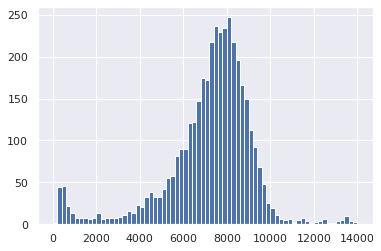

In [131]:
plt.hist(np.hstack(data3.sc_integral), bins=70, range=(xmin,xmax), label=label)
plt.show()

In [135]:
data11 = np.histogram(np.hstack(data1.sc_integral), bins=70, range=(xmin,xmax))
data22 = np.histogram(np.hstack(data1.sc_integral), bins=70, range=(xmin,xmax))
data33 = np.histogram(np.hstack(data1.sc_integral)) + np.hstack(data2.sc_integral)

ValueError: operands could not be broadcast together with shapes (2160,) (2143,) 

In [6]:
def fill_image(df):
    image = np.zeros((2304, 2304), dtype=np.int64)
    for i, event in enumerate(df.event):

        image[df.redpix_ix[event], df.redpix_iy[event]]= \
        image[df.redpix_ix[event], df.redpix_iy[event]] + df.redpix_iz[event]
    return image
run      = 44076
run_name = '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/'+'reco_run{0:05d}_3D.pkl.gz'.format(run)
dfall=pd.read_pickle(run_name, compression={'method': 'gzip'})

1.43e+07
1 1


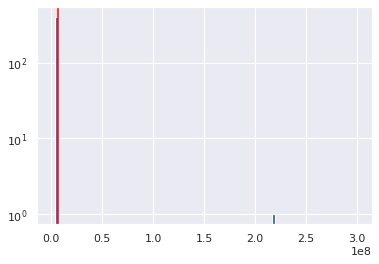

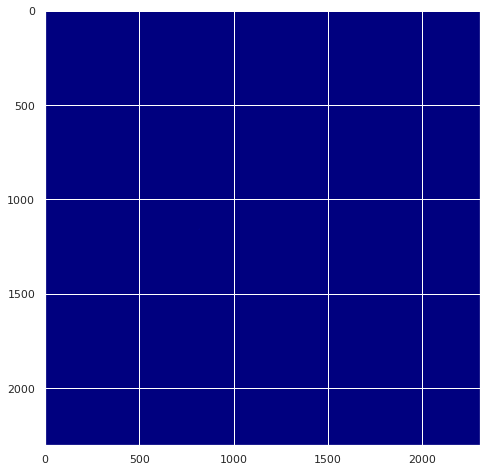

In [76]:
SPARK_reco    = 2304**2+9*1e6
print('{:.2e}'.format(SPARK_reco))
SPARK         = 0.64e7
print(len(dfall[dfall.cmos_integral>SPARK]),len(dfall[dfall.cmos_integral>SPARK_reco]))
plt.hist(np.hstack(dfall.cmos_integral), log=True, bins=100, range=(0.1e7,30e7))
plt.axvline(SPARK, color='red')
plt.show()
image = fill_image(dfall[dfall.cmos_integral>SPARK])
plt.figure(figsize=(8,8))
plt.imshow(image, vmin=0, vmax=100, cmap='jet')
plt.show()

In [131]:
bins=100
ist = np.zeros(bins)
for run in range(17362, 18362):#39638
    try:
        if runInfo[runInfo.run_number==run].source_type.values[0]==0:
            print(run)
            run_name = '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/'+'reco_run{0:05d}_3D.pkl.gz'.format(run)
            dfall=pd.read_pickle(run_name, compression={'method': 'gzip'})
            new,_ = np.histogram(np.hstack(dfall.cmos_integral), bins=bins, range=(0.1e7,1e7))
            ist = ist+new
       
    except Exception as e:
        print("ERROR>>> ", e)

ERROR>>>  [Errno 2] No such file or directory: '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/reco_run17817_3D.pkl.gz'
ERROR>>>  [Errno 2] No such file or directory: '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/reco_run17829_3D.pkl.gz'
ERROR>>>  [Errno 2] No such file or directory: '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/reco_run17838_3D.pkl.gz'
ERROR>>>  [Errno 2] No such file or directory: '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/reco_run17847_3D.pkl.gz'
ERROR>>>  [Errno 2] No such file or directory: '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/reco_run17856_3D.pkl.gz'
ERROR>>>  [Errno 2] No such file or directory: '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/reco_run17865_3D.pkl.gz'
ERROR>>>  [Errno 2] No such file or directory: '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/reco_run17874_3D.pkl.gz'
ERROR>>>  [Errno 2] No such file or directory: '/jupyter-workspace/cloud-storage/cygno-analysis/pkl/reco_run17883_3D.pkl.gz'


No handles with labels found to put in legend.


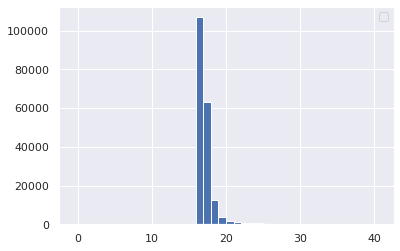

In [139]:
plt_hist_from_hist(ist[20:60], verbose=False)